# Zalando Image Dataset

## Setup

In [1]:
!wget https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-images-idx3-ubyte.gz -O ./data/t10k-images-idx3-ubyte.gz
!wget https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-labels-idx1-ubyte.gz -O ./data/t10k-labels-idx1-ubyte.gz
!wget https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/train-images-idx3-ubyte.gz -O ./data/train-images-idx3-ubyte.gz
!wget https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/train-labels-idx1-ubyte.gz -O ./data/train-labels-idx1-ubyte.gz

--2022-02-10 18:28:40--  https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-images-idx3-ubyte.gz
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-images-idx3-ubyte.gz [following]
--2022-02-10 18:28:40--  https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-images-idx3-ubyte.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4422102 (4.2M) [application/octet-stream]
Saving to: './data/t10k-images-idx3-ubyte.gz'

     0K .......... .......... .......... .......... ..

In [2]:
!wget https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/utils/mnist_reader.py -O mnist_reader.py

--2022-02-10 18:29:13--  https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/utils/mnist_reader.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 756 [text/plain]
Saving to: 'mnist_reader.py'

     0K                                                       100% 2.23M=0s

2022-02-10 18:29:14 (2.23 MB/s) - 'mnist_reader.py' saved [756/756]



In [4]:
import mnist_reader
X_train, y_train = mnist_reader.load_mnist('data', kind='train')
X_test, y_test = mnist_reader.load_mnist('data', kind='t10k')

## Preprocessing

The data set contains 60.000 images.

In [9]:
X_train.shape

(60000, 784)

These are all 28 by 28 grayscale images.

In [8]:
28 * 28

784

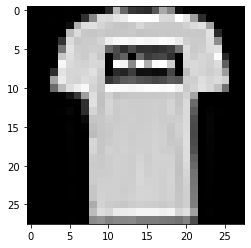

In [18]:
from matplotlib import pyplot as plt
from PIL import Image

example_image = Image.fromarray(X_train[1].reshape(28, 28), mode='P')
plt.imshow(example_image)

### Simple feature extraction

The simple features that will be extracted are the following:

* binned grayscale values (bin size 32)
* number of black pixels
* number of almost white pixels (any pixel higher or equal to 250)
* average grayscale value of 7x7 pixel regions (16 values in total)

[45.857142857142854, 61.857142857142854, 0.22448979591836735, 0.08163265306122448, 160.6734693877551, 175.3265306122449, 174.89795918367346, 169.0612244897959, 160.14285714285714, 170.6734693877551, 207.9795918367347, 199.26530612244898, 81.95918367346938, 88.77551020408163, 12.346938775510203, 17.367346938775512]
297
18


[335, 25, 24, 22, 13, 16, 293, 56]

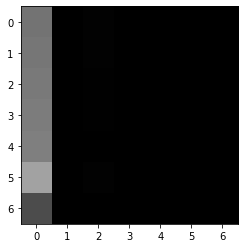

In [78]:
from functools import reduce
from math import sqrt
import numpy as np

def feature_extraction_zalando(image):
  black_indicator = lambda aggregator, x: aggregator+1 if x == 0 else aggregator+0
  almost_white_indicator = lambda aggregator, x: aggregator+1 if x >= 250 else aggregator+0
  n_black = reduce(black_indicator, image, 0)
  n_almost_white = reduce(almost_white_indicator, image, 0)
  print(n_black)
  print(n_almost_white)

def make_bin(list, min, max, bin_range):
  arr = [0] * int((max - min) / bin_range)
  for i in list:
    bin = int(i / bin_range)
    arr[bin] = arr[bin] + 1
  return arr

def variance(data):
  # Number of observations
  n = len(data)
  # Mean of the data
  mean = sum(data) / n
  # Square deviations
  deviations = [(x - mean) ** 2 for x in data]
  # Variance
  variance = sum(deviations) / n
  return variance

def min_max_normed(data):
  print(max(data))
  return np.array([int((x / max(data)) * 256) for x in data])

def compute_region_relative_brightness(image, region_width):
  avg_regions = []
  #normed_image = min_max_normed(image)
  im = Image.fromarray(image.reshape(28, 28), mode="P")
  for left in range(0, 28, region_width):
    for top in range(0, 28, region_width):
      cropped = im.crop((left, top, left + region_width, top + region_width))
      plt.imshow(cropped)
      avg_regions.append(
          np.average(get_grayscale_pixels(cropped))
      )
  return avg_regions
  
def get_grayscale_pixels(image):
  pix = []
  width, height = image.size
  for i in range(0, width):
    for j in range(0, height):
      pix.append(image.getpixel((i,j)))
  return pix
  
print(compute_region_relative_brightness(X_train[1], 7))

feature_extraction_zalando(X_train[1])
make_bin(X_train[1], 0, 256, 32)